# JSC Assignment 2: Soccer!

In this scenario, you're designing a decision-support tool for coaches and managers of soccer teams.  The goal is to make a demo that shows what kinds of insights are possible using this dataset.



## Questions your report should answer:

### What value you could add with this data?  For example:
 - Support coaches in giving feedback,
 - Identify which players are over-performing or under-performing
 - Help understand trends in the game.

### How will you measure success?  Identify:
 - What the ultimate goal is, even if it's hard to measure (better soccer playing? more entertaining soccer? saving money on player salaries?) Suggestion:  Try to determine how coaches are judged.
 - Suggest some proxies of that that are easier to quantify, e.g. games won, goals scored, ad money.
 - Say how you'll chose your models (e.g. predictive accuracy)
 - Say what loss you'll use to train your model (e.g. log-likelihood)

### Look at the data.
  - Try to find outliers / problems in data.
  - Give a sense of the amount of relevant data you have to support each prediction.  How many shots per player are in the database?
  - Look for signs of saturation / overly-coarse data.  What could we expect to do better with finer-grained data?

### Brainstorm complementary sources of data.
  - E.g. More detailed information about players, video, commentaries.

### Brainstorm a comprehensive list of factors that could affect the recorded data.
  - What are all the factors that could conceivably influence the recorded outcomes?  E.g. bad calls by refs, games being cancelled, bad teams dropping out of tournaments, mislabeling do to similar jersey numbers, medical conditions of the players, synergy between teammates...
  - This section just needs to be a list of all the factors that we might conceivably want to model or know in order to improve our predictions.  The purpose is to make sure that when you're making your model, you're keeping in mind what a limited representation it is of a complicated reality.  10-20 factors should be sufficient.  This doesn't have to be a formal model.

### Propose a model staircase (series of more sophisticated models)
  
  - You don't have to implement every model you propose!
  - It doesn't have to be a strict staircase (each model doesn't have to incorporate the one before it).
  - You can propose models that you don't know how to implement.
  - Ideally, differences between results will make it clear which inputs / parts of the model are important.
  - You need to implement as many model refinements or variants as there are members of your group.
  - Suggested variants:
      - Adapting training to handle imbalanced data.
      - Look up timestamps of games and investigate trends. What things are changing over time, or depend on seasons?
      - Use a neural net (or other model) instead of logistic regression.
      - Add a latent variable per-player, and examing the latent vectors.

### Attempt to explain the model
  - Investigate which features were important.
  - Make only true and meaningful statements, even if they are vague.  E.g. in a logistic regression model, if a coefficient is positive, you could say that "According to the model, if all else is held fixed, but this feature is higher, the probability of a goal will be higher."
  - State the main results of your model in relatively plain language.
  - Include one or two sanity checks, e.g. that accuracy is lower for players with few shots, or shots from far away are less likely to succeed.

### Report evidence it works, expected value added, conditions for accurate use.
  - Spell out what question the model is answering.
  - Spell out what question your train/test splits were answering.  Should correspond to how to shuffled + split the data when training.
  - Make improvement clear in terms of your metrics over some baseline.  E.g. "our best model has x% lower recall than simply guessing the mean".
  - Make a link between your improvement of this metric and some metric that a decision-maker might care about.  E.g. "X% of games are lost by one goal, so replacing one underperforming player with one with median performance will lead to Y more games won per season on average".  It's OK to estimate numbers, just make it clear where you're doing so.
  - Make statements about what would increase or decrease the accuracy of the model over time.  E.g. many new players would hurt accuracy.

Assignments will be graded according to [these rubrics](https://jsc370.github.io/2020/assignment_rubrics.html)

In [1]:
# Data originally from https://www.kaggle.com/secareanualin/football-events
# Related analysis at https://www.kaggle.com/gabrielmanfredi/expected-goals-player-analysis

!wget https://jsc370.github.io/events.csv.zip
!unzip events.csv.zip

!wget https://jsc370.github.io/ginf.csv.zip
!unzip ginf.csv.zip

!wget https://jsc370.github.io/dictionary.txt


--2021-02-06 05:27:54--  https://jsc370.github.io/events.csv.zip
Resolving jsc370.github.io (jsc370.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to jsc370.github.io (jsc370.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21797089 (21M) [application/zip]
Saving to: ‘events.csv.zip.8’

events.csv.zip.8    100%[===================>]  20.79M  --.-KB/s    in 0.09s   

2021-02-06 05:27:54 (232 MB/s) - ‘events.csv.zip.8’ saved [21797089/21797089]

Archive:  events.csv.zip
replace events.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
--2021-02-06 05:28:02--  https://jsc370.github.io/ginf.csv.zip
Resolving jsc370.github.io (jsc370.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to jsc370.github.io (jsc370.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344339 (336K) [application/zip]
Saving to: ‘ginf.csv.zip.3’

ginf.csv.zip.3

In [2]:
import pandas as pd
import jax.numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import jax.numpy as jnp
import numpy.random as npr
from jax.api import jit, grad

In [3]:
events = pd.read_csv('events.csv')
info = pd.read_csv('ginf.csv')

In [4]:
events.head()

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,dennis diekmeier,dennis diekmeier,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,heiko westermann,heiko westermann,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,sven bender,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,gokhan tore,NaN,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0


In [5]:
events.shape

(941009, 22)

In [6]:
info.head()

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,D1,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
2,bkjpaC6n/,/soccer/germany/bundesliga-2011-2012/werder-br...,True,2011-08-06,D1,2012,germany,Werder Bremen,Kaiserslautern,2,0,1.83,4.20,4.80,NaN,NaN,NaN,NaN
3,CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,F1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
4,GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,F1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN


In [7]:
# considering data from particular event ( " 1 = Attempt to shot")
shots = events[events.event_type==1]

In [8]:
shots.head()

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0
11,UFot0hit/,UFot0hit12,12,14,Attempt missed. Shinji Kagawa (Borussia Dortmu...,1,12.0,1,Borussia Dortmund,Hamburg SV,shinji kagawa,mario gotze,NaN,NaN,13.0,2.0,0,15.0,1.0,1,1.0,0
13,UFot0hit/,UFot0hit14,14,17,"Goal! Borussia Dortmund 1, Hamburg 0. Kevin G...",1,12.0,1,Borussia Dortmund,Hamburg SV,kevin grosskreutz,mario gotze,NaN,NaN,4.0,1.0,1,9.0,2.0,1,1.0,0
14,UFot0hit/,UFot0hit15,15,19,Attempt blocked. Mats Hummels (Borussia Dortmu...,1,NaN,1,Borussia Dortmund,Hamburg SV,mats hummels,NaN,NaN,NaN,2.0,3.0,0,15.0,1.0,0,1.0,0
17,UFot0hit/,UFot0hit18,18,20,Attempt blocked. Tomas Rincon (Hamburg) right ...,1,NaN,2,Hamburg SV,Borussia Dortmund,tomas rincon,NaN,NaN,NaN,2.0,3.0,0,15.0,1.0,0,1.0,0


In [9]:
# # one-hot encoding (binary representation of fature values)

# data = pd.get_dummies(shots.iloc[:,-6:-1], columns=['location', 'bodypart','assist_method', 'situation'])
# data.columns = ['fast_break', 'loc_centre_box', 'loc_diff_angle_lr', 'diff_angle_left', 'diff_angle_right',
#                 'left_side_box', 'left_side_6ybox', 'right_side_box', 'right_side_6ybox', 'close_range',
#                 'penalty', 'outside_box', 'long_range', 'more_35y', 'more_40y', 'not_recorded', 'right_foot', 
#                 'left_foot', 'header', 'no_assist', 'assist_pass', 'assist_cross', 'assist_header',
#                 'assist_through_ball', 'open_play', 'set_piece', 'corner', 'free_kick']
# data['is_goal'] = shots['is_goal']


In [10]:
# one-hot encoding (binary representation of fature values)

data = pd.get_dummies(shots[["is_goal","bodypart","situation"]], columns=['bodypart', 'situation'])
data.columns =  ['is_goal','right_foot', 'left_foot', 'header', 'open_play', 'set_piece', 'corner', 'free_kick']



In [11]:
data.head()

,is_goal,right_foot,left_foot,header,open_play,set_piece,corner,free_kick
0,0,0,1,0,1,0,0,0
11,0,1,0,0,1,0,0,0
13,1,0,1,0,1,0,0,0
14,0,1,0,0,1,0,0,0
17,0,1,0,0,1,0,0,0


In [12]:
print(len(data))
print(data.is_goal.sum())
print(len(data.columns)-1)

229135
24441
7


In [13]:
# train test split and format data.
X = data.drop(["is_goal"],axis =1)
y = data["is_goal"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train = np.float32(np.array(X_train))
X_test = np.float32(np.array(X_test))
y_train = np.float32(np.array(y_train))
y_test = np.float32(np.array(y_test))

c_train = np.ones((X_train.shape[0], 1))               # intercept 
X_train = np.concatenate((c_train, X_train), axis=1)   # Add intercept to the original feature set
c_test = np.ones((X_test.shape[0], 1)) 
X_test = np.concatenate((c_test, X_test), axis=1)


In [14]:
# Simple logistic regression model.

from jax.api import vmap   # Takes a function that operates on a single
                           # example, and vectorizes it to work on a batch.

epochs = 20
learning_rate = 1.0

theta = np.zeros(X_train.shape[1])       # initialize weights 

def sigmoid(z):
  return 1.0 / (1.0 + np.exp(-z))

def logreg_pred(params, X):
  return sigmoid(np.dot(X, params))

def log_bernoulli(y, p):
  return np.mean(y * np.log(p) + (1.0 - y) * np.log(1.0 - p))

def single_loss(params, X, y):
  return -log_bernoulli(y, logreg_pred(params, X))

def batch_loss(params, X, y):
  vectorized_logprob = vmap(single_loss, (None, 0, 0))  # Vectorize over X and y.
  return np.mean(vectorized_logprob(params, X, y))

def accuracy(params, x, y):
  pred = logreg_pred(params, x)
  return 100.0 * np.mean(np.round(pred) == y)

print(grad(batch_loss)(theta, X_train, y_train))

train_loss = [] # loss history 

for i in range(epochs):
  theta = theta - learning_rate * grad(batch_loss)(theta, X_train, y_train)
  
  loss_tr = batch_loss(theta, X_train, y_train)
  train_loss.append(loss_tr)
  train_accuracy = accuracy(theta, X_train, y_train)
  test_accuracy = accuracy(theta, X_test, y_test)
  print(i, loss_tr, np.mean(train_accuracy), np.mean(test_accuracy))


[0.39307082 0.20688951 0.12631471 0.05986646 0.34710723 0.00963406
 0.02761745 0.00871211]
0 0.44439882 89.30707 89.43854
1 0.38095924 89.30707 89.43854
2 0.3574914 89.30707 89.43854
3 0.34678337 89.30707 89.43854
4 0.34127116 89.30707 89.43854
5 0.33819884 89.30707 89.43854
6 0.33638188 89.30707 89.43854
7 0.33525255 89.30707 89.43854
8 0.33451793 89.30707 89.43854
9 0.33401775 89.30707 89.43854
10 0.3336612 89.30707 89.43854
11 0.3333948 89.30707 89.43854
12 0.3331863 89.30707 89.43854
13 0.33301625 89.30707 89.43854
14 0.33287218 89.30707 89.43854
15 0.33274618 89.30707 89.43854
16 0.3326335 89.30707 89.43854
17 0.33253074 89.30707 89.43854
18 0.33243558 89.30707 89.43854
19 0.3323467 89.30707 89.43854


(array([38702.,     0.,     0.,     0.,     0.,     0.,  1687.,  3074.,
         1533.,   831.]),
 array([0.09075968, 0.10471921, 0.11867875, 0.13263828, 0.14659782,
        0.16055734, 0.17451687, 0.18847641, 0.20243594, 0.21639548,
        0.23035501], dtype=float32),
 <a list of 10 Patch objects>)

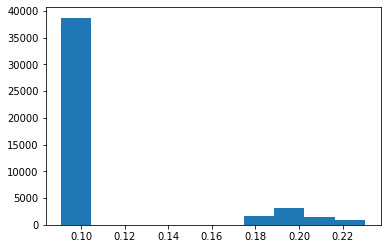

In [15]:
theta

plt.hist(logreg_pred(theta, X_test))

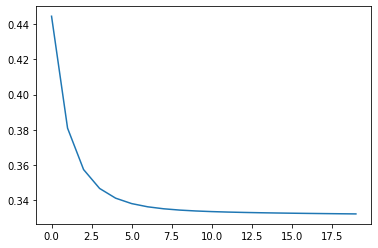

In [16]:
iterations = range(epochs)
plt.plot(iterations, train_loss)

In [17]:
ypred = logreg_pred(theta, X_test)
p = pd.DataFrame(np.around(ypred, decimals=4))
p['pred'] = p[0].apply(lambda x : 0 if x < 0.5 else 1)
print(classification_report(y_test , p['pred'].values))

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     40987
         1.0       0.00      0.00      0.00      4840

    accuracy                           0.89     45827
   macro avg       0.45      0.50      0.47     45827
weighted avg       0.80      0.89      0.84     45827



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
